<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Kullback-Leibler (KL) Divergence

Kullback-Leibler (KL) Divergence is a measure of how one probability distribution is different from a second, reference probability distribution. Smaller KL Divergence values indicate more similar distributions and, since this loss function is differentiable, we can use gradient descent to minimize the KL divergence between network outputs and some target distribution. As an example, this can be used in Variational Autoencoders (VAEs), and reinforcement learning policy networks such as [Trust Region Policy Optimization (TRPO)](https://arxiv.org/abs/1502.05477).

In MXNet Gluon, we can use [KLDivLoss](../../../../api/gluon/loss/index.rst#mxnet.gluon.loss.KLDivLoss) to compare categorical distributions. One important thing to note is that the KL Divergence is an asymmetric measure (i.e. `KL(P,Q) != KL(Q,P)`): order matters and we should compare our predicted distribution with our target distribution in that order. Another thing to note is that there are two ways to use [KLDivLoss](../../../../api/gluon/loss/index.rst#mxnet.gluon.loss.KLDivLoss) that depend on how we set `from_logits` (which has a default value of true). 

As an example, let's compare a few categorical distributions (`dist_1`, `dist_2` and `dist_3`), each with 4 categories.

Text(0.5, 1.0, 'Distributions 1 & 3')

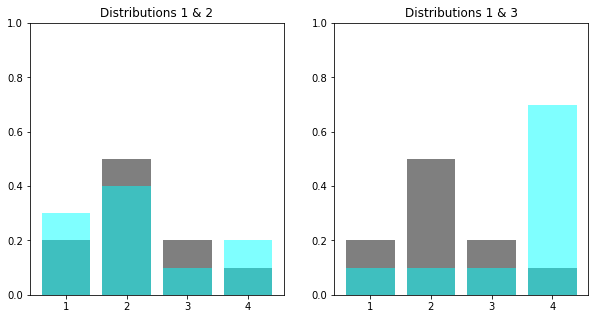

In [1]:
from matplotlib import pyplot as plt
import mxnet as mx
import numpy as np

idx = np.array([1, 2, 3, 4])
dist_1 = np.array([0.2, 0.5, 0.2, 0.1])
dist_2 = np.array([0.3, 0.4, 0.1, 0.2])
dist_3 = np.array([0.1, 0.1, 0.1, 0.7])

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.ylim(top=1)
plt.bar(idx, dist_1, alpha=0.5, color='black')
plt.bar(idx, dist_2, alpha=0.5, color='aqua')
plt.title('Distributions 1 & 2')
plt.subplot(1,2,2)
plt.ylim(top=1)
plt.bar(idx, dist_1, alpha=0.5, color='black')
plt.bar(idx, dist_3, alpha=0.5, color='aqua')
plt.title('Distributions 1 & 3')

We can see visually that distributions 1 and 2 are more similar than distributions 1 and 3. We'll confirm this result using [KLDivLoss](../../../../api/gluon/loss/index.rst#mxnet.gluon.loss.KLDivLoss). When using [KLDivLoss](../../../../api/gluon/loss/index.rst#mxnet.gluon.loss.KLDivLoss) with the default `from_logits=True` we need:

1. our predictions to be parameters of a logged probability distribution.
2. our targets to be parameters of a probability distribution (i.e. not logged).

We often apply a [softmax](../../../../api/npx/generated/mxnet.npx.softmax.rst) operation to the output of our network to get a distribution, but this can have a numerically unstable gradient calculation. As as stable alternative, we use [log_softmax](../../../../api/npx/generated/mxnet.npx.log_softmax.rst) and so this is what is expected by [KLDivLoss](../../../../api/gluon/loss/index.rst#mxnet.gluon.loss.KLDivLoss) when `from_logits=True`. We also usually work with batches of predictions, so the predictions and targets need to have a batch dimension (the first axis by default).

Since we're already working with distributions in this example, we don't need to apply the softmax and only need to apply [log](../../../../api/np/generated/mxnet.np.log.rst). And we'll create batch dimensions even though we're working with single distributions.

In [2]:
def kl_divergence(dist_a, dist_b):
    # add batch dimension
    pred_batch = mx.np.expand_dims(mx.np.array(dist_a), axis=0)
    target_batch = mx.np.expand_dims(mx.np.array(dist_b), axis=0)
    # log the distribution
    pred_batch = mx.np.log(pred_batch)
    # create loss (assuming we have a logged prediction distribution)
    loss_fn = mx.gluon.loss.KLDivLoss(from_logits=True)
    divergence = loss_fn(pred_batch, target_batch)
    return divergence.item()

In [3]:
print("Distribution 1 compared with Distribution 2: {}".format(
        kl_divergence(dist_1, dist_2)))
print("Distribution 1 compared with Distribution 3: {}".format(
        kl_divergence(dist_1, dist_3)))
print("Distribution 1 compared with Distribution 1: {}".format(
        kl_divergence(dist_1, dist_1)))

Distribution 1 compared with Distribution 2: 0.025424212217330933
Distribution 1 compared with Distribution 3: 0.2656409740447998
Distribution 1 compared with Distribution 1: 0.0


[22:08:40] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for CPU


As expected we see a smaller KL Divergence for distributions 1 & 2 than 1 & 3. And we also see the KL Divergence of a distribution with itself is 0.

#### `from_logits=False`

Alternatively, instead of manually applying the [log_softmax](../../../../api/npx/generated/mxnet.npx.log_softmax.rst) to our network outputs, we can leave that to the loss function. When setting `from_logits=False` on [KLDivLoss](../../../../api/gluon/loss/index.rst#mxnet.gluon.loss.KLDivLoss), the [log_softmax](../../../../api/npx/generated/mxnet.npx.log_softmax.rst) is applied to the first argument passed to `loss_fn`. As an example, let's assume our network outputs us the values below (favorably chosen so that when we [softmax](../../../../api/npx/generated/mxnet.npx.softmax.rst) these values we get the same distribution parameters as `dist_1`).

In [4]:
output = mx.np.array([0.39056206, 1.3068528, 0.39056206, -0.30258512])

We can pass this to our [KLDivLoss](../../../../api/gluon/loss/index.rst#mxnet.gluon.loss.KLDivLoss) loss function (with `from_logits=False`) and get the same KL Divergence between `dist_1` and `dist_2` as before, because the [log_softmax](../../../../api/npx/generated/mxnet.npx.log_softmax.rst) is applied within the loss function.

In [5]:
def kl_divergence_not_from_logits(dist_a, dist_b):
    # add batch dimension
    pred_batch = mx.np.expand_dims(mx.np.array(dist_a), axis=0)
    target_batch = mx.np.expand_dims(mx.np.array(dist_b), axis=0)
    # create loss (assuming we have a logged prediction distribution)
    loss_fn = mx.gluon.loss.KLDivLoss(from_logits=False)
    divergence = loss_fn(pred_batch, target_batch)
    return divergence.item()

In [6]:
print("Distribution 1 compared with Distribution 2: {}".format(
        kl_divergence_not_from_logits(output, dist_2)))

Distribution 1 compared with Distribution 2: 0.025424206629395485


### Advanced: Common Support

Occasionally, you might have issues with [KLDivLoss](../../../../api/gluon/loss/index.rst#mxnet.gluon.loss.KLDivLoss). One common issue arises when the support of the distributions being compared are not the same. 'Support' here is referring to the values of the distribution which have a non-zero probability. Conveniently, all our examples above had the same support, but we might have a case where some categories have a probability of 0.

In [7]:
dist_4 = np.array([0, 0.9, 0, 0.1])

In [8]:
print("Distribution 4 compared with Distribution 1: {}".format(
        kl_divergence(dist_4, dist_1)))

Distribution 4 compared with Distribution 1: nan


We can see that the result is `nan`, which will obviously cause issues when calculating the gradient. One option is to add a small value `epsilon` to all of the probabilities, and this is already done for the target distribution (using the value of 1e-12).

### Advanced: Aggregation

One minor difference between the true definition of KL Divergence and the result from [KLDivLoss](../../../../api/gluon/loss/index.rst#mxnet.gluon.loss.KLDivLoss) is how the aggregation of category contributions is performed. Although the true definition sums up these contributions, the default behaviour in MXNet Gluon is to average terms along the batch dimension. As a result, the [KLDivLoss](../../../../api/gluon/loss/index.rst#mxnet.gluon.loss.KLDivLoss) output will be smaller than the true definition by a factor of the number of categories.

In [9]:
true_divergence = (dist_2*(np.log(dist_2)-np.log(dist_1))).sum()
print('true_divergence: {}'.format(true_divergence))

true_divergence: 0.10169682996275987


```{.python .input}
num_categories = dist_1.shape[0]
divergence = kl_divergence(dist_1, dist_2)
print('divergence: {}'.format(divergence))
print('divergence * num_categories: {}'.format(divergence * num_categories))
```